In [58]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity

In [59]:
def l2_normalize_vectors(arr: np.ndarray) -> np.ndarray:
    """
    Normalize vectors to unit length (L2 norm) along the last axis.

    Handles zero vectors safely by preventing division by zero.

    Args:
        arr: Input array of vectors (1D or 2D)

    Returns:
        L2-normalized array of unit vectors
    """
    if arr.ndim == 1:
        arr = arr.reshape(1, -1)

    norms = np.linalg.norm(arr, axis=1, keepdims=True)
    norms[norms == 0] = 1.0  # Avoid division by zero
    return arr / norms


def non_negative_project(arr: np.ndarray) -> np.ndarray:
    """
    Project vectors into non-negative space while preserving direction.

    This transformation maintains angular relationships by:
    1. Taking absolute values (folding into first quadrant)
    2. Re-normalizing to unit length

    Args:
        arr: Input array of vectors (1D or 2D)

    Returns:
        Non-negative unit vectors in the range [0, 1] per component
    """
    return l2_normalize_vectors(np.abs(arr))


def safe_cosine_similarity(
    array: np.ndarray, vector: np.ndarray, non_negative: bool = False
) -> np.ndarray:
    """
    Compute cosine similarity with optional non-negative transformation.

    Ensures proper handling of:
    - Different value ranges
    - Negative values
    - Vector normalization

    Args:
        array: 2D array of shape (n_samples, n_features)
        vector: 1D vector of shape (n_features,) or 2D vector (1, n_features)
        non_negative: Whether to project into non-negative space

    Returns:
        1D array of cosine similarities between vector and each array row
    """
    # Ensure proper vector shapes
    array = np.atleast_2d(array)
    vector = vector.reshape(1, -1)  # Ensure 2D row vector

    # Normalize to unit vectors
    norm_array = l2_normalize_vectors(array)
    norm_vector = l2_normalize_vectors(vector)

    # Optional non-negative projection
    if non_negative:
        norm_array = non_negative_project(norm_array)
        norm_vector = non_negative_project(norm_vector)

    # Compute cosine similarity (dot product of normalized vectors)
    return cosine_similarity(norm_array, norm_vector).flatten()

In [60]:
def plot_vector_transformation(vectors, normalized_vectors, non_neg_projected, weights):
    """
    Plots vector transformations with centered axes and proper scaling.

    Shows:
    1. Original vectors
    2. L2-normalized vectors (unit circle)
    3. Non-negative projected vectors

    Args:
        vectors: 2D numpy array of shape (n_vectors, 2)
    """

    # Create figure with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # Common settings
    for ax in (ax1, ax2, ax3):
        ax.axhline(0, color="gray", linestyle="--", linewidth=0.5)
        ax.axvline(0, color="gray", linestyle="--", linewidth=0.5)
        ax.grid(True)
        ax.set_aspect("equal")

    # Plot weights vector in the 3 subplots
    weights_vector = np.array(weights).reshape(1, -1)
    for ax in (ax1, ax2, ax3):
        ax.quiver(
            0,
            0,
            weights_vector[0, 0],
            weights_vector[0, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="black",
            width=0.01,
            label="Weights Vector",
        )

    # Plot 1: Original vectors
    ax1.set_title("Original Vectors")
    ax1.set_xlim(-1.5 * np.max(np.abs(vectors)), 1.5 * np.max(np.abs(vectors)))
    ax1.set_ylim(-1.5 * np.max(np.abs(vectors)), 1.5 * np.max(np.abs(vectors)))
    for i, (x, y) in enumerate(vectors):
        ax1.quiver(
            0,
            0,
            x,
            y,
            angles="xy",
            scale_units="xy",
            scale=1,
            color=plt.cm.tab10(i),
            width=0.005,
            label=f"Vec {i + 1}",
        )

    # Plot 2: L2-normalized vectors (unit circle)
    ax2.set_title("L2-Normalized Vectors")
    ax2.set_xlim(-1.2, 1.2)
    ax2.set_ylim(-1.2, 1.2)
    # Draw unit circle
    circle = plt.Circle((0, 0), 1, color="gray", fill=False, linestyle="--")
    ax2.add_patch(circle)
    for i, (x, y) in enumerate(normalized_vectors):
        ax2.quiver(
            0,
            0,
            x,
            y,
            angles="xy",
            scale_units="xy",
            scale=1,
            color=plt.cm.tab10(i),
            width=0.005,
            label=f"Vec {i + 1}",
        )

    # Plot 3: Non-negative projected vectors
    ax3.set_title("Non-Negative Projection")
    ax3.set_xlim(-1.2, 1.2)
    ax3.set_ylim(-1.2, 1.2)
    for i, (x, y) in enumerate(non_neg_projected):
        ax3.quiver(
            0,
            0,
            x,
            y,
            angles="xy",
            scale_units="xy",
            scale=1,
            color=plt.cm.tab10(i),
            width=0.005,
            label=f"Vec {i + 1}",
        )

    # Add legends
    ax1.legend(loc="lower right")
    ax2.legend(loc="lower right")
    ax3.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

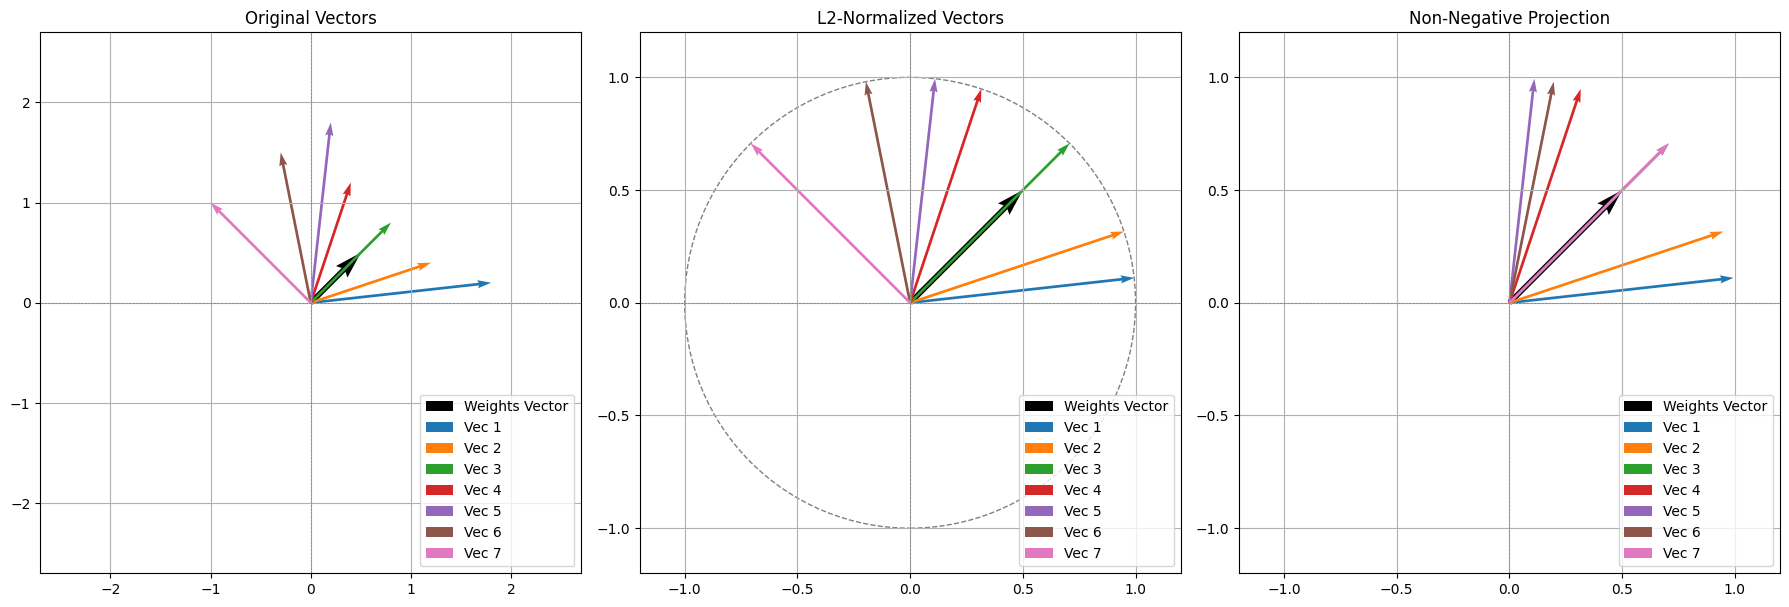

Standard cosine similarity:
[0.78086881 0.89442719 1.         0.89442719 0.78086881 0.83205029
 1.        ]

Non-negative cosine similarity:
[0.78086881 0.89442719 1.         0.89442719 0.78086881 0.83205029
 1.        ]
Non-negative cosine similarity (with projection):
[[0.99388373 0.11043153]
 [0.9486833  0.31622777]
 [0.70710678 0.70710678]
 [0.31622777 0.9486833 ]
 [0.11043153 0.99388373]
 [0.19611614 0.98058068]
 [0.70710678 0.70710678]]

Most similar vector (standard): [0.70710678 0.70710678]


In [61]:
# Test data with mixed signs and ranges
vectors = np.array(
    [
        [1.8, 0.2],  # High x, low y
        [1.2, 0.4],
        [0.8, 0.8],  # Balanced
        [0.4, 1.2],
        [0.2, 1.8],  # Low x, high y
        [-0.3, 1.5],  # Extending to Q2
        [-1.0, 1.0],  # Q2 extreme
    ]
)

# Transform vectors
normalized = l2_normalize_vectors(vectors)
non_neg_vectors = non_negative_project(normalized)

weights = np.array([0.5, 0.5])  # [0,1] range

plot_vector_transformation(vectors, normalized, non_neg_vectors, weights)


# Standard cosine similarity (handles negatives)
sims = safe_cosine_similarity(non_neg_vectors, weights)
print("Standard cosine similarity:")
print(sims)

# Non-negative version
non_neg_sims = safe_cosine_similarity(non_neg_vectors, weights, non_negative=True)
print("\nNon-negative cosine similarity:")
print(non_neg_sims)

print("Non-negative cosine similarity (with projection):")
# Non-negative cosine similarity with projection
print(non_neg_vectors)

# Find best match
most_similar_idx = np.argmax(non_neg_sims)
print(f"\nMost similar vector (standard): {non_neg_vectors[most_similar_idx]}")

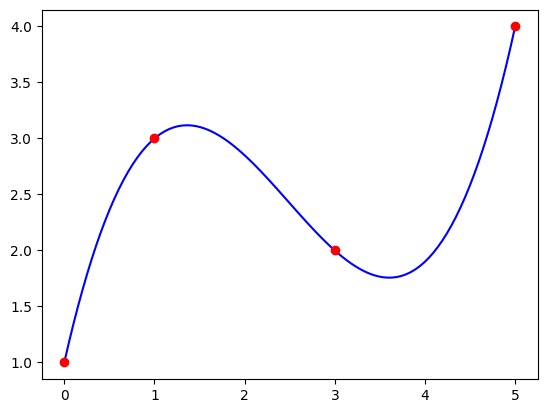

In [26]:
# Python polynomial interpolation example
import matplotlib.pyplot as plt
import numpy as np

x = np.array([0, 1, 3, 5])
y = np.array([1, 3, 2, 4])
coefficients = np.polyfit(x, y, deg=3)  # 4 points → cubic polynomial
poly = np.poly1d(coefficients)

x_new = np.linspace(0, 5, 100)
plt.plot(x_new, poly(x_new), "b-", label="Polynomial Fit")
plt.plot(x, y, "ro", label="Data Points")

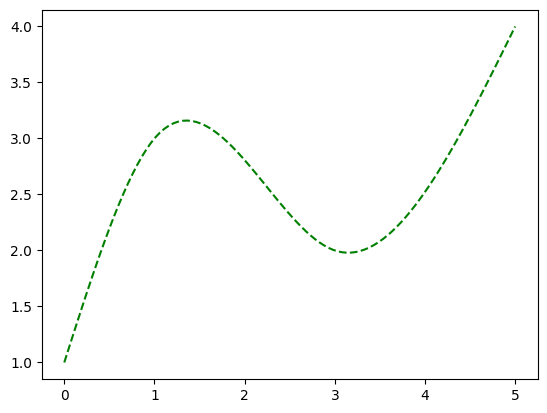

In [27]:
# Python cubic spline example
from scipy.interpolate import CubicSpline

cs = CubicSpline(x, y, bc_type="natural")  # Natural boundary conditions
plt.plot(x_new, cs(x_new), "g--", label="Cubic Spline")